In [2]:
# First let's set up our packages
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

# And set some constants
c = 299792.458 # km/s (speed of light)
H0kmsmpc = 70.  # Hubble constant in km/s/Mpc
H0s = H0kmsmpc * 3.2408e-20 # H0 in inverse seconds is H0 in km/s/Mpc * (3.2408e-20 Mpc/km)

# Write a function for the integrand, i.e. $1/E(z)$,
def ezinv(z,om=0.3,ol=0.7,w0=-1.0,wa=0.0,orr=0.0):
    ok = 1.-om-ol-orr
    a  = 1./(1.+z)
    f = a**(3*(1.+w0+wa)) * np.exp(3*wa*(1-a))
    ez = np.sqrt( orr/a**4 + om/a**3 + ok/a**2 + ol/f )
    return 1./ez

# The curvature correction function
def Sk(xx, ok):
    if ok < 0.0:
        dk = np.sin(np.sqrt(-ok)*xx)/np.sqrt(-ok)
    elif ok > 0.0:
        dk = np.sinh(np.sqrt(ok)*xx)/np.sqrt(ok)
    else:
        dk = xx
    return dk

# The distance modulus
def dist_mod(zs,om=0.3,ol=0.7,w0=-1.0,wa=0.0,orr=0.0):
    """ Calculate the distance modulus, correcting for curvature"""
    ok = 1.0 - om - ol
    z_array = np.linspace(0.01,1,50)
    xx_array = np.array([integrate.quad(ezinv, 0, z, args=(om, ol, w0, wa, orr))[0] for z in z_array])
    xx = np.interp(zs, z_array, xx_array)
    #xx = np.array([integrate.quad(ezinv, 0, z, args=(om, ol, w0, wa, orr))[0] for z in zs])
    D = Sk(xx, ok)
    lum_dist = D * (1 + zs) 
    dist_mod = 5 * np.log10(lum_dist) # Distance modulus
    # Add an arbitrary constant that's approximately the log of c on Hubble constant minus absolute magnitude of -19.5
    dist_mod = dist_mod + np.log(c/H0kmsmpc)-(-19.5)  # You can actually skip this step and it won't make a difference to our fitting
    return dist_mod



In [3]:
# Add a new function that reads in the data (data files should be in a directory called data)
def read_data(model_name):
    d = np.genfromtxt('data/'+model_name+'.txt',delimiter=',')
    zs = d[:,0]
    mu = d[:,1]
    muerr=d[:,2]
    # Sort the arrays based on zs
    sort_idx = np.argsort(zs)
    zs = zs[sort_idx]
    mu = mu[sort_idx]
    muerr = muerr[sort_idx]
    return zs, mu, muerr

zs, mu, muerr = read_data('realdata')

#################
# Temporarily halve muerr for testing
#muerr = muerr/2 
#################



In [4]:
# Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
n = 50                   # Increase this for a finer grid
oms = np.linspace(0.1, 0.5, n)   # Array of matter densities
ols = np.linspace(0.2, 1.0, n)   # Array of cosmological constant values
w0s = np.linspace(-1.5, -0.5, n)   # Array of cosmological constant values
wa = 0

chi2_3d = np.ones((n, n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values   
chi2_3d_prior = np.ones((n, n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values  
chi2_3d_prior2 = np.ones((n, n, n)) * np.inf
chi2_3d_withprior = np.ones((n, n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values   

#LOAD_SAVED=True #for saving runs
#if LOAD_SAVED:
#   chi2_3d = np.load('chi2_3d.npy')  
#   print(chi2_3d)   
#else:    
    # Calculate Chi2 for each model #prior from 2018 study ()
for i, om in enumerate(oms):                                          # loop through matter densities
    chi2_3d_prior2[i,:,:] = ((om-0.27)/0.03)**2                 #prior to matter
    for j, ol in enumerate(ols):                                  # loop through cosmological constant densities
        chi2_3d_prior[i,j,:] = ((om+ol-1.0)/0.02)**2              #flatness prior/result from handout
        for k, w0 in enumerate(w0s):
            mu_model = dist_mod(zs, om=om, ol=ol, w0=w0)              # calculate the distance modulus vs redshift for that model 
            mu_model_norm = mu_model-np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Apply the vertical offset
            chi2_3d[i,j,k] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix 
chi2_3d_withprior = chi2_3d+chi2_3d_prior+chi2_3d_prior2 #total prior
#np.save('chi2_3d.npy',chi2_3d)
#np.save('chi2_3d_withprior.npy',chi2_3d_withprior)



In [4]:
##For no prior
# Convert that to a likelihood and calculate the reduced chi2
likelihood_3d = np.exp(-0.5 * (chi2_3d-np.amin(chi2_3d)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
likelihood_3d = likelihood_3d /np.sum(likelihood_3d)        # normalise so the total likelihood = 1.0.
chi2_reduced = chi2_3d / (len(mu)-2)                       # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# Calculate the best fit values (where chi2 is minimum)
indbest_3d = np.argmin(chi2_3d)                 # Gives index of best fit but where the indices are just a single number
ibest_3d   = np.unravel_index(indbest_3d,[n,n,n]) # Converts the best fit index to the 3d version (i,j,k)
print(w0s[ibest_3d[2]])
print( 'Best fit values are (om,ol,w0)=(%.3f,%.3f,%.3f)'%( oms[ibest_3d[0]], ols[ibest_3d[1]], w0s[ibest_3d[2]] ) )
print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest_3d[0],ibest_3d[1],ibest_3d[2]] )

# Turn 3d likelihoods into 2d arrays 
likelihood_3domol = np.sum(likelihood_3d,2)
likelihood_3domw0 = np.sum(likelihood_3d,1)
likelihood_3dolw0 = np.sum(likelihood_3d,0)

# Turn 2d likelihoods into 1d arrays
likelihood_3dom = np.sum(likelihood_3domol,1)
likelihood_3dol = np.sum(likelihood_3dolw0,1)
likelihood_3dw0 = np.sum(likelihood_3dolw0,0)


##FOR flat prior
# Convert that to a likelihood and calculate the reduced chi2
likelihood_3d_flat = np.exp(-0.5 * (chi2_3d_prior-np.amin(chi2_3d_prior)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
likelihood_3d_flat = likelihood_3d_flat /np.sum(likelihood_3d_flat)        # normalise so the total likelihood = 1.0.

# Turn 3d likelihoods into 2d arrays 
likelihood_3domol_flat = np.sum(likelihood_3d_flat,2)
likelihood_3domw0_flat = np.sum(likelihood_3d_flat,1)
likelihood_3dolw0_flat = np.sum(likelihood_3d_flat,0)


##FOR matter prior
# Convert that to a likelihood and calculate the reduced chi2
likelihood_3d_mat = np.exp(-0.5 * (chi2_3d_prior2-np.amin(chi2_3d_prior2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
likelihood_3d_mat = likelihood_3d_mat /np.sum(likelihood_3d_mat)        # normalise so the total likelihood = 1.0.

# Turn 3d likelihoods into 2d arrays 
likelihood_3domol_mat = np.sum(likelihood_3d_mat,2)
likelihood_3domw0_mat = np.sum(likelihood_3d_mat,1)
likelihood_3dolw0_mat = np.sum(likelihood_3d_mat,0)



##FOR PRIORS
likelihood_3d_prior = np.exp(-0.5 * (chi2_3d_withprior-np.amin(chi2_3d)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
likelihood_3d_prior = likelihood_3d_prior /np.sum(likelihood_3d_prior)        # normalise so the total likelihood = 1.0.
chi2_reduced_prior = chi2_3d_withprior / (len(mu)-2)                       # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# Calculate the best fit values (where chi2 is minimum)
indbest_3d_prior = np.argmin(chi2_3d_withprior)                 # Gives index of best fit but where the indices are just a single number
ibest_3d_prior   = np.unravel_index(indbest_3d_prior,[n,n,n]) # Converts the best fit index to the 3d version (i,j,k)
print(w0s[ibest_3d_prior[2]])
print( 'Best fit values are (om,ol,w0)=(%.3f,%.3f,%.3f)'%( oms[ibest_3d_prior[0]], ols[ibest_3d_prior[1]], w0s[ibest_3d_prior[2]] ) )
print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest_3d_prior[0],ibest_3d_prior[1],ibest_3d_prior[2]] )

# Turn 3d likelihoods into 2d arrays 
likelihood_3domol_prior = np.sum(likelihood_3d_prior,2)
likelihood_3domw0_prior = np.sum(likelihood_3d_prior,1)
likelihood_3dolw0_prior = np.sum(likelihood_3d_prior,0)

# Turn 2d likelihoods into 1d arrays
likelihood_3dom_prior = np.sum(likelihood_3domol_prior,1)
likelihood_3dol_prior = np.sum(likelihood_3dolw0_prior,1)
likelihood_3dw0_prior = np.sum(likelihood_3dolw0_prior,0)

-1.9
Best fit values are (om,ol,w0)=(0.100,0.230,-1.900)
Reduced chi^2 for the best fit is 1.70
-0.8721518987341772
Best fit values are (om,ol,w0)=(0.252,0.747,-0.872)
Reduced chi^2 for the best fit is 1.70


Best fit values in 2D are ($\Omega_m$,$\Omega_l$)=(0.100,0.251)
Best fit values in 2D are ($\Omega_m$,$\Omega_l$)=(0.100,0.230)
Best fit values in 2D are ($\Omega_m$,$w_0$)=(0.100,-0.677)
Best fit values in 2D are ($\Omega_m$,$w_0$)=(0.100,-1.900)
Best fit values in 2D are ($w_0$,$\Omega_l$)=(-1.900,0.251)
Best fit values in 2D are ($w_0$,$\Omega_l$)=(-1.900,0.230)


C:\Users\Noah\AppData\Local\Temp\ipykernel_13196\380740352.py:32: UserWarning: No contour levels were found within the data range.
  ax.contour(x,y,np.transpose(pri1-np.amin(pri1)),cmap="copper",**{'levels':levels}) #flatness prior
C:\Users\Noah\AppData\Local\Temp\ipykernel_13196\380740352.py:33: UserWarning: No contour levels were found within the data range.
  ax.contour(x,y,np.transpose(pri2-np.amin(pri2)),cmap="twilight_shifted",**{'levels':levels}) #matter prior


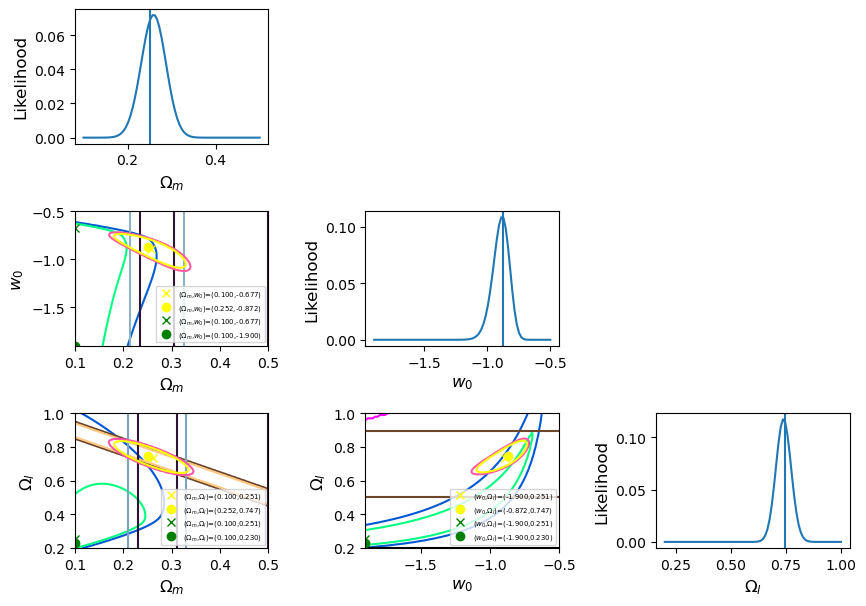

In [5]:
def find_levels(likearr2d):
	# find the likelihood level that encloses 1sigma, 2sigma, and 3sigma of the likelihood (approximately)
	nlevel=50
	tot = np.zeros(nlevel)
	levels = np.linspace(0,np.max(likearr2d),nlevel)
	for i,level in enumerate(levels):
		tot[i] = np.sum(likearr2d[likearr2d>level])
	isig1 = (np.abs(tot - 0.6827)).argmin()
	isig2 = (np.abs(tot - 0.9245)).argmin()
	isig3 = (np.abs(tot - 0.9973)).argmin()
	return np.array([levels[isig3],levels[isig2],levels[isig1]])


def plot_1d(x,y,xlabel,ylabel,xbest,ax,filename='plots/temp.png'):
    ax.plot(x,y)
    ax.axvline(x=xbest)
    ax.set_xlabel(xlabel, fontsize=12)
    #ax.set_ylabel_position("right")
    ax.set_ylabel(ylabel, fontsize=12)
    #ax.savefig(filename,bbox_inches='tight')
    #ax.close()

def plot_contour(x,y,z,pri1,pri2,pri_tot,xlabel,ylabel,xbest_pri,ybest_pri,xbest,ybest,ax,filename='plots/temp.png'):
    indbest_2d_pri = np.argmax(pri_tot)             # Gives index of best fit but where the indices are just a single number
    ibest_2d_pri   = np.unravel_index(indbest_2d_pri,[n,n]) # Converts the best fit index to the 3d version (i,j,k)
    indbest_2d = np.argmax(z)             # Gives index of best fit but where the indices are just a single number
    ibest_2d   = np.unravel_index(indbest_2d,[n,n]) # Converts the best fit index to the 3d version (i,j,k)
    print( 'Best fit values in 2D are (%s,%s)=(%.3f,%.3f)'%( xlabel,ylabel,x[ibest_2d[0]], y[ibest_2d[1]]))
    print( 'Best fit values in 2D are (%s,%s)=(%.3f,%.3f)'%( xlabel,ylabel,xbest, ybest))
    levels = find_levels(z)
    ax.contour(x,y,np.transpose(z-np.amin(z)),cmap="winter",**{'levels':levels}) #basic data
    ax.contour(x,y,np.transpose(pri1-np.amin(pri1)),cmap="copper",**{'levels':levels}) #flatness prior
    ax.contour(x,y,np.transpose(pri2-np.amin(pri2)),cmap="twilight_shifted",**{'levels':levels}) #matter prior
    ax.contour(x,y,np.transpose(pri_tot-np.amin(pri_tot)),cmap="spring",**{'levels':levels}) #matter prior
    ax.plot(x[ibest_2d_pri[0]], y[ibest_2d_pri[1]],'x',color='yellow',label='(%s,%s)=(%.3f,%.3f)'%(xlabel,ylabel,x[ibest_2d_pri[0]],y[ibest_2d_pri[1]]) )
    ax.plot(xbest_pri, ybest_pri,'o',color='yellow',label='(%s,%s)=(%.3f,%.3f)'%(xlabel,ylabel,xbest_pri,ybest_pri) )
    ax.plot(x[ibest_2d[0]], y[ibest_2d[1]],'x',color='green',label='(%s,%s)=(%.3f,%.3f)'%(xlabel,ylabel,x[ibest_2d[0]],y[ibest_2d[1]]) )
    ax.plot(xbest, ybest,'o',color='green',label='(%s,%s)=(%.3f,%.3f)'%(xlabel,ylabel,xbest,ybest) )
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(frameon=True,fontsize="5",loc='lower right')
    #ax.savefig(filename, bbox_inches='tight')
    #ax.close()

    
#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3,sharex=True, sharey=True)
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,7))

ax2.set_visible(False)
ax3.set_visible(False)
ax6.set_visible(False)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
#fig.savefig('plots/all_plot.png')


    
#For ALL
plot_contour(oms,ols,likelihood_3domol,likelihood_3domol_flat,likelihood_3domol_mat,likelihood_3domol_prior,"$\Omega_m$","$\Omega_l$",oms[ibest_3d_prior[0]],ols[ibest_3d_prior[1]],oms[ibest_3d[0]],ols[ibest_3d[1]],ax7,filename='plots/contours_omol.png')
plot_contour(oms,w0s,likelihood_3domw0,likelihood_3domw0_flat,likelihood_3domw0_mat,likelihood_3domw0_prior,"$\Omega_m$","$w_0$",oms[ibest_3d_prior[0]],w0s[ibest_3d_prior[2]],oms[ibest_3d[0]],w0s[ibest_3d[2]],ax4,filename='plots/contours_omw0.png')
plot_contour(w0s,ols,likelihood_3dolw0.T,likelihood_3dolw0_flat.T,likelihood_3dolw0_mat.T,likelihood_3dolw0_prior.T,"$w_0$","$\Omega_l$",w0s[ibest_3d_prior[2]],ols[ibest_3d_prior[1]],w0s[ibest_3d[2]],ols[ibest_3d[1]],ax8,filename='plots/contours_olw0.png')


##FOR No PRIOR
#plot_contour(oms,ols,likelihood_3domol,"$\Omega_m$","$\Omega_l$",oms[ibest_3d[0]],ols[ibest_3d[1]],filename='plots/contours_omol_noprior.png',)
#plot_contour(oms,w0s,likelihood_3domw0,"$\Omega_m$","$w_0$",oms[ibest_3d[0]],w0s[ibest_3d[2]],filename='plots/contours_omw0_noprior.png')
#plot_contour(ols,w0s,likelihood_3dolw0,"$\Omega_l$","$w_0$",ols[ibest_3d[1]],w0s[ibest_3d[2]],filename='plots/contours_olw0_noprior.png')


##FOR total PRIOR
#plot_contour(oms,ols,likelihood_3domol,"$\Omega_m$","$\Omega_l$",oms[ibest_3d_prior[0]],ols[ibest_3d_prior[1]],filename='plots/contours_omol_prior.png',)
#plot_contour(oms,w0s,likelihood_3domw0,"$\Omega_m$","$w_0$",oms[ibest_3d_prior[0]],w0s[ibest_3d_prior[2]],filename='plots/contours_omw0_prior.png')
#plot_contour(ols,w0s,likelihood_3dolw0,"$\Omega_l$","$w_0$",ols[ibest_3d_prior[1]],w0s[ibest_3d_prior[2]],filename='plots/contours_olw0_prior.png')

##1d likelywood plots for all
plot_1d(oms,likelihood_3dom_prior,"$\Omega_m$","Likelihood",oms[ibest_3d_prior[0]],ax1,filename='plots/like_om_prior.png')
plot_1d(ols,likelihood_3dol_prior,"$\Omega_l$","Likelihood",ols[ibest_3d_prior[1]],ax9,filename='plots/like_ol_prior.png')
plot_1d(w0s,likelihood_3dw0_prior,"$w_0$","Likelihood",w0s[ibest_3d_prior[2]],ax5,filename='plots/like_w0_prior.png')



Current problems for prior plots:
1. There is a ol prior showing up in the olw0 plot

Notes about plots:
1. for plotting, all the dots and crosses are the best for the total prior plot
2. when comparing the all plot and total prior plot the central contours change size